In [1]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
from src.kernels import RBFAID
import tensorflow as tf
import tensorflow_probability  as tfp
import pods

2023-08-30 14:25:27.819810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sensors_names = ['root','lowerback','upperback','thorax','lowerneck','upperneck','head','rclavicle','rhumerus','rradius','rwrist','rhand','rfingers','rthumb','lclavicle','lhumerus','lradius','lwrist','lhand','lfingers','lthumb','rfemur','rtibia','rfoot','rtoes','lfemur','ltibia','lfoot','ltoes']
sensors_measures = [6,3,3,3,3,3,3,2,3,1,1,2,1,2,2,3,1,1,2,1,2,3,1,2,1,3,1,2,1]
s_names_measures = []
for i, sensor_name in enumerate(sensors_names):
  s_names_measures.append([sensor_name] * sensors_measures[i])
mask = [31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 54, 61]
mask_sensors_names = [11,12,13,18,19,20,24,28]
s_names_measures = np.array([item for s_names_measures in s_names_measures for item in s_names_measures])
s_names_measures_50 = np.delete(s_names_measures, mask, 0).tolist()
s_sep_50 = np.cumsum(np.delete(np.array(sensors_measures), mask_sensors_names, 0))
sensors_measures_21 = np.insert(s_sep_50, 0, 0)
sensors_names_21 = list(dict.fromkeys(s_names_measures_50))
measures_per_sensor_50 = np.delete(np.array(sensors_measures), mask_sensors_names, 0)

In [25]:
mocap09 = np.load('data/mocap/mocap09.npz')['data']
mocap07 = np.load('data/mocap/mocap07.npz')['data']
mocap08 = np.load('data/mocap/mocap08.npz')['data']
mocap16 = np.load('data/mocap/mocap16.npz')['data']
walk = mocap09.shape[0] + mocap16.shape[0]
run =  mocap07.shape[0] +  mocap08.shape[0]

In [26]:
#  Sub-sampling of 1/8 [ss]
rate = 8
mask = np.zeros(mocap09.shape[1], dtype=int)
mask[::rate] = 1
mocap09 = mocap09[:,mask==1,:]
mask = np.zeros(mocap08.shape[1], dtype=int)
mask[::rate] = 1
mocap08 = mocap08[:,mask==1,:]
mask = np.zeros(mocap07.shape[1], dtype=int)
mask[::rate] = 1
mocap07 = mocap07[:,mask==1,:]
mask = np.zeros(mocap16.shape[1], dtype=int)
mask[::rate] = 1
mocap16 = mocap16[:,mask==1,:]

In [27]:
# Level the second dimension (time)
T = np.min([mocap09.shape[1], mocap07.shape[1], mocap08.shape[1], mocap16.shape[1]])
mocap09 = mocap09[:,0:T,:]
mocap07 = mocap07[:,0:T,:]
mocap08 = mocap08[:,0:T,:]
mocap16 = mocap16[:,0:T,:]
print('mocap07: ', mocap09.shape)
print('mocap08: ', mocap08.shape)
print('mocap09: ', mocap07.shape)
print('mocap16: ', mocap16.shape)

mocap07:  (10, 15, 50)
mocap08:  (10, 15, 50)
mocap09:  (11, 15, 50)
mocap16:  (6, 15, 50)


In [28]:
# Take just first measure of each sensor
def select_first_measure(x):
    N, T, D = x.shape
    d = 21
    x_stacked = np.vstack([x[i] for i in range(x.shape[0])])
    x_stacked_first_measure = np.empty((N*T, d))
    i = 0
    j = 0
    for sensor_n_measures in measures_per_sensor_50:
        x_stacked_sensor = x_stacked[:,i:i+sensor_n_measures] # NT x S
        x_ = x_stacked_sensor[:,0:1]
        x_stacked_first_measure[:,j:j+1] = x_
        j += 1
        i += sensor_n_measures
    x_ = np.concatenate([np.expand_dims(x_stacked_first_measure[i * T:(i + 1) * T], 0) for i in range(N)], 0)
    return x_
mocap09 = select_first_measure(mocap09)
mocap07 = select_first_measure(mocap07)
mocap08 = select_first_measure(mocap08)
mocap16 = select_first_measure(mocap16)

In [29]:
# Merge data to create Y
Y_original = np.vstack((mocap09, mocap16, mocap07, mocap08))
# Treat zero readings
if Y_original.shape[2] == 21:
    Y_original[:,:,(7,11)] = 1e-6
else:
    Y_original[:,:,(24, 25, 31, 32)] = 1e-6
# Normalize
data_std = Y_original[:, :].std((0, 1), keepdims=True) + 1e-5
data_mean = Y_original[:, :].mean((0, 1), keepdims=True)
Y_original = (Y_original - data_mean) / data_std
print('Y_original: ',Y_original.shape)
# Reshape
Y = Y_original.reshape(Y_original.shape[0],-1)
print('Y flat: ',Y.shape) # N x [D repeated T times]

Y_original:  (37, 15, 21)
Y flat:  (37, 315)


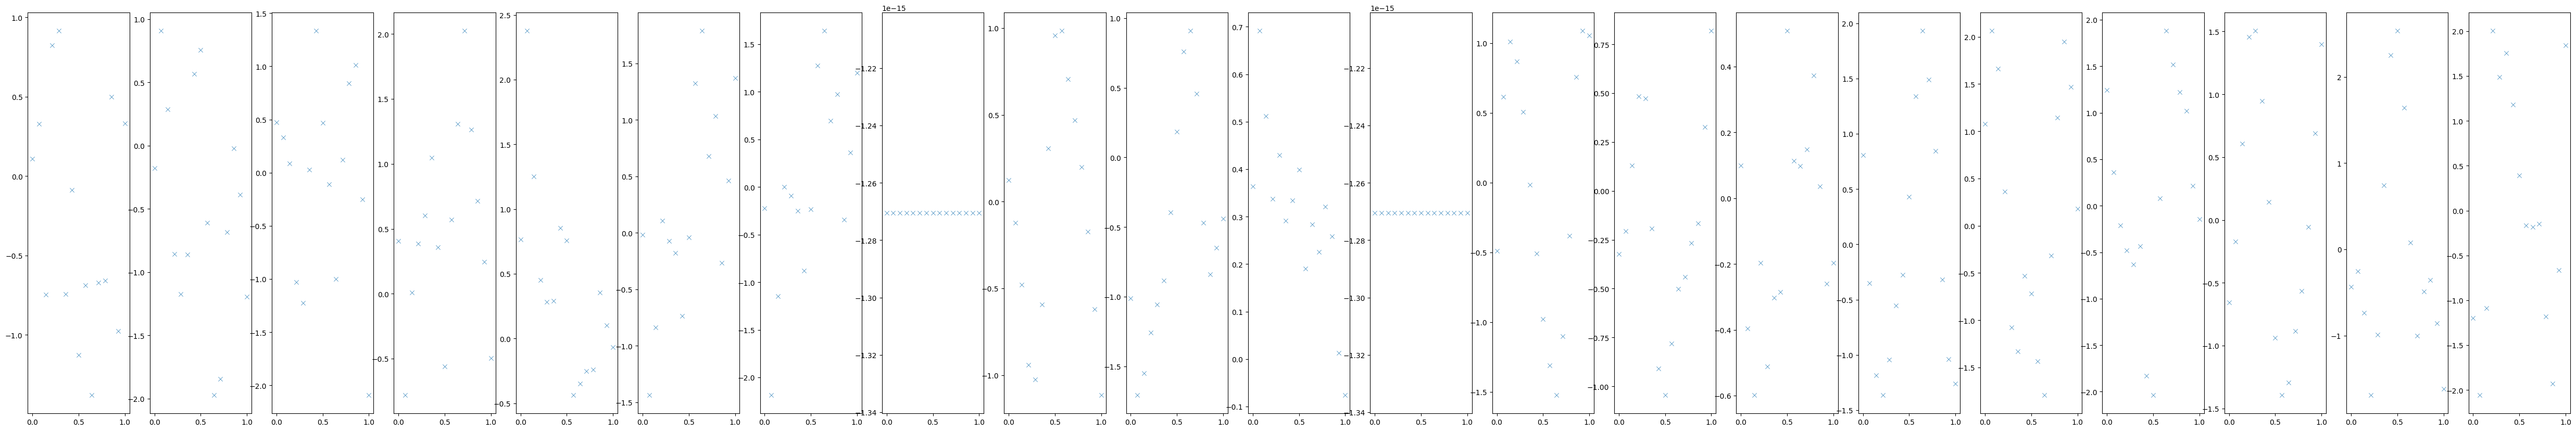

In [30]:
sample = 0
fig, axs = plt.subplots(1, Y_original.shape[2], figsize=(Y_original.shape[2]*3, 10))
for i in range(Y_original.shape[2]):
    sensor = Y[sample].reshape(Y_original.shape[1], Y_original.shape[2])
    sns.scatterplot(x=np.linspace(0,1,Y_original.shape[1]), y=sensor[:,i], ax=axs[i], marker="x")

In [31]:
# Define target labels (1:run, 0:walk)
labels = np.concatenate((np.ones(run), np.zeros(walk)))[:,None]
print('labels: ',labels.shape)

labels:  (37, 1)


In [32]:
# Try the RBFAID kernel
D = 21
T = 15
kernel_single_sum=RBFAID(variance=0.1, randomized=False, D=D, T=T, kernel_computation_type='single_sum')
kernel_double_sum=RBFAID(variance=0.1, randomized=False, D=D, T=T, kernel_computation_type='double_sum')
sample_i = 10
sample_j = 5

In [33]:
# Double sum
sample_i = 10
sample_j = 5
k = []
for t_i in range(T):
    for t_j in range(T):
        y_ti = Y_original[sample_i,:,:][t_i][:,None]
        y_tj = Y_original[sample_j,:,:][t_j][:,None]
        k.append(0.1*np.exp(-0.5*(y_ti-y_tj).T @ kernel_double_sum.precision() @ (y_ti-y_tj)))
print(np.sum(np.array(k)), kernel_double_sum.K(Y,Y)[sample_i,sample_j])

10.805592058612827 tf.Tensor(10.805592058612831, shape=(), dtype=float64)


In [34]:
# Single sum
sample_i = 10
sample_j = 5
k = []
for t_i in range(T):
    for t_j in range(T):
        if t_i == t_j:
            y_ti = Y_original[sample_i,:,:][t_i][:,None]
            y_tj = Y_original[sample_j,:,:][t_j][:,None]
            k.append(0.1*np.exp(-0.5*(y_ti-y_tj).T @ kernel_single_sum.precision() @ (y_ti-y_tj)))
print(np.sum(np.array(k)), kernel_single_sum.K(Y,Y)[sample_i,sample_j])

0.6022766463295252 tf.Tensor(0.6022766463295252, shape=(), dtype=float64)


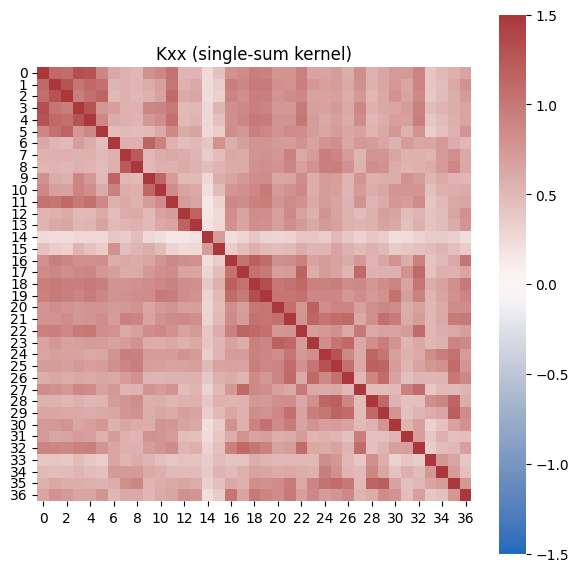

In [35]:
# Kernel matrix visualization
Kxx = kernel_single_sum.K(Y,Y)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(Kxx, annot=False, square=True, cmap='vlag', vmax=np.max(Kxx), vmin=-np.max(Kxx), center=0, ax=ax)
ax.set_title('Kxx (single-sum kernel)')
plt.show()

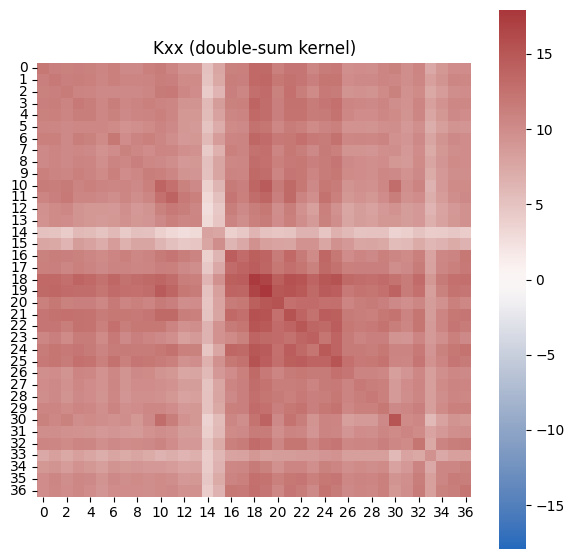

In [36]:
# Kernel matrix visualization
Kxx = kernel_double_sum.K(Y,Y)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(Kxx, annot=False, square=True, cmap='vlag', vmax=np.max(Kxx), vmin=-np.max(Kxx), center=0, ax=ax)
ax.set_title('Kxx (double-sum kernel)')
plt.show()

In [38]:
# Train VGP classifier
D = 21
T = 15
m = gpflow.models.VGP(
    (Y, labels), 
    likelihood=gpflow.likelihoods.Bernoulli(), 
    kernel=RBFAID(variance=0.1, randomized=False, D=D, T=T, kernel_computation_type='single_sum')
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18.141879075681167
        x: [ 1.365e+00  7.165e-01 ...  6.042e-02  2.434e-02]
      nit: 272
      jac: [ 4.757e-05  9.826e-05 ...  9.629e-05  4.068e-04]
     nfev: 287
     njev: 287
 hess_inv: <971x971 LbfgsInvHessProduct with dtype=float64>

In [39]:
Fmean, _ = m.predict_f(Y)
Psamples = m.likelihood.invlink(Fmean)
Y_pred = np.array([int(i) for i in Psamples >= 0.5]).reshape(-1,1)
print('Train Accuracy: ', np.sum(Y_pred  ==  labels) / Y_pred.shape[0])

Train Accuracy:  1.0


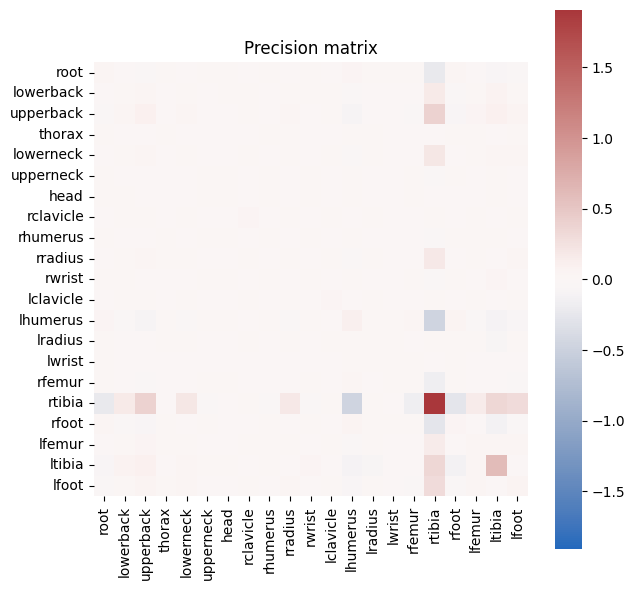

In [43]:
sensors_names_21 = list(dict.fromkeys(s_names_measures_50))
Lambda = m.kernel.precision()
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(Lambda, annot=False, square=True, cmap='vlag', vmax=np.max(Lambda), vmin=-np.max(Lambda), center=0, ax=ax)
ax.set_xticklabels(sensors_names_21)
ax.set_yticklabels(sensors_names_21)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
ax.set_title('Precision matrix')
plt.show()

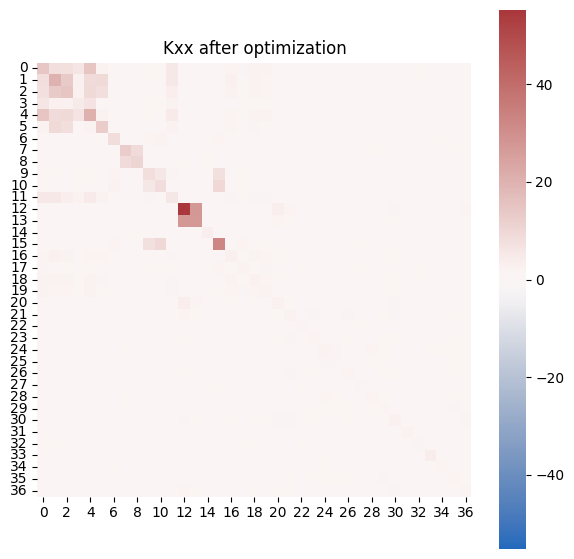

In [42]:
Kxx = m.kernel.K(Y,Y)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(Kxx, annot=False, square=True, cmap='vlag', vmax=np.max(Kxx), vmin=-np.max(Kxx), center=0, ax=ax)
ax.set_title('Kxx after optimization')
plt.show()